In [1]:
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.pde import solve2D, ExampleGenerator2D, Monitor2D
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Homogeneous Dirichlet B.C on a Circular Boundary

The way to impose a Dirichlet boundary conditions on a circle $||\vec{x}||^2 = r^2$ is to have a function $L_D(\vec{x})$ which is 0.0 on the boundary but non zero elsewhere. And example $L_D(\vec{x})$ is:

$$
L_D(\vec{x}) = r^2 - (||\vec{x}||^2)
$$

In this case, our trial solution would be:

$$
\psi_t(\vec{x}) = A_D(\vec{x}) + L_D(\vec{x})N(\vec{x})
$$

where $N(\vec{x})$ is the output of the neural net and $A_D(\vec{x})$ is a function that satisfies the Dirichlet boundary condition on the boundary, so that on the boundary where $L_D(\vec{x}) = 0$, the second term vanishes and our trial solution will satisfy the Dirichlet boundary condition exactly.

This can be extended to boundaries with more complex geometry later. The method is to map the domain into a circle such that $||\vec{\tilde{x}}||^2 = r^2$ by some some function $map(\vec{x})$. And the $L_D(\vec{x})$ will then be:

$$
L_D(\vec{x}) = r^2 - (||map(\vec{x})||^2)
$$

In [2]:
r = 1
def L_D(dimensions):
    return r**2 - sum(d**2 for d in dimensions)

In [3]:
xs = torch.linspace(-1, 1, 101)
ys = torch.linspace(-1, 1, 101)
xx, yy = torch.meshgrid(xs, ys)
xx, yy = xx.reshape(-1, 1), yy.reshape(-1, 1)
ld = L_D((xx, yy))

What $L_D(\vec{x})$ looks like:

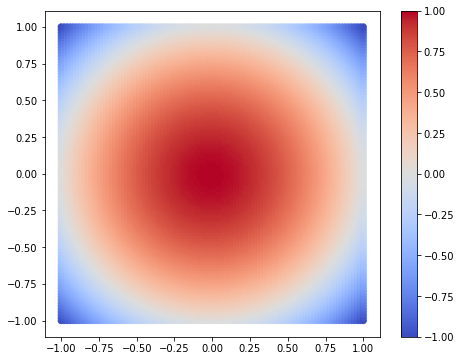

In [4]:
fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.scatter(xx.flatten(), yy.flatten(), c=ld.flatten(), cmap='coolwarm')
cbar = fig.colorbar(cs)

In [5]:
def _nn_output(net, xyz_etc, ith):
    original_shape  = xyz_etc[0].shape
    xyz_etc = torch.cat(xyz_etc, 1)
    output = net(xyz_etc)
    return output[:, ith].reshape(original_shape)

In [6]:
class CircularDirichletHomogeneous:
    
    def __init__(self, r, val=0.0, ith=0):
        def L_D(dimensions):
            return r**2 - sum(d**2 for d in dimensions)
        def A_D(dimensions):
            return val
        self.L_D = L_D
        self.A_D = A_D
        self.ith = ith
        
    def enforce(self, net, *dimensions):
        return self.A_D(dimensions) + self.L_D(dimensions)*_nn_output(net, dimensions, self.ith)
    
    def set_impose_on(self, ith):
        self.ith = ith

Poisson in circular domain where

$$
\partial_x^2 u + \partial_y^2 u = 1
$$

$$
x^2 + y^2 \leq 1
$$

s.t.

$$
u(x, y) = 0 \text{ when } x^2 + y^2 = 1
$$

Solution is

$$
u(x, y) = \frac{1}{4}(x^2 + y^2) - \frac{1}{4}
$$

In [7]:
def solution_analytical_poisson(xx, yy):
    return 0.25 * (xx**2 + yy**2) - 0.25

<IPython.core.display.Javascript object>


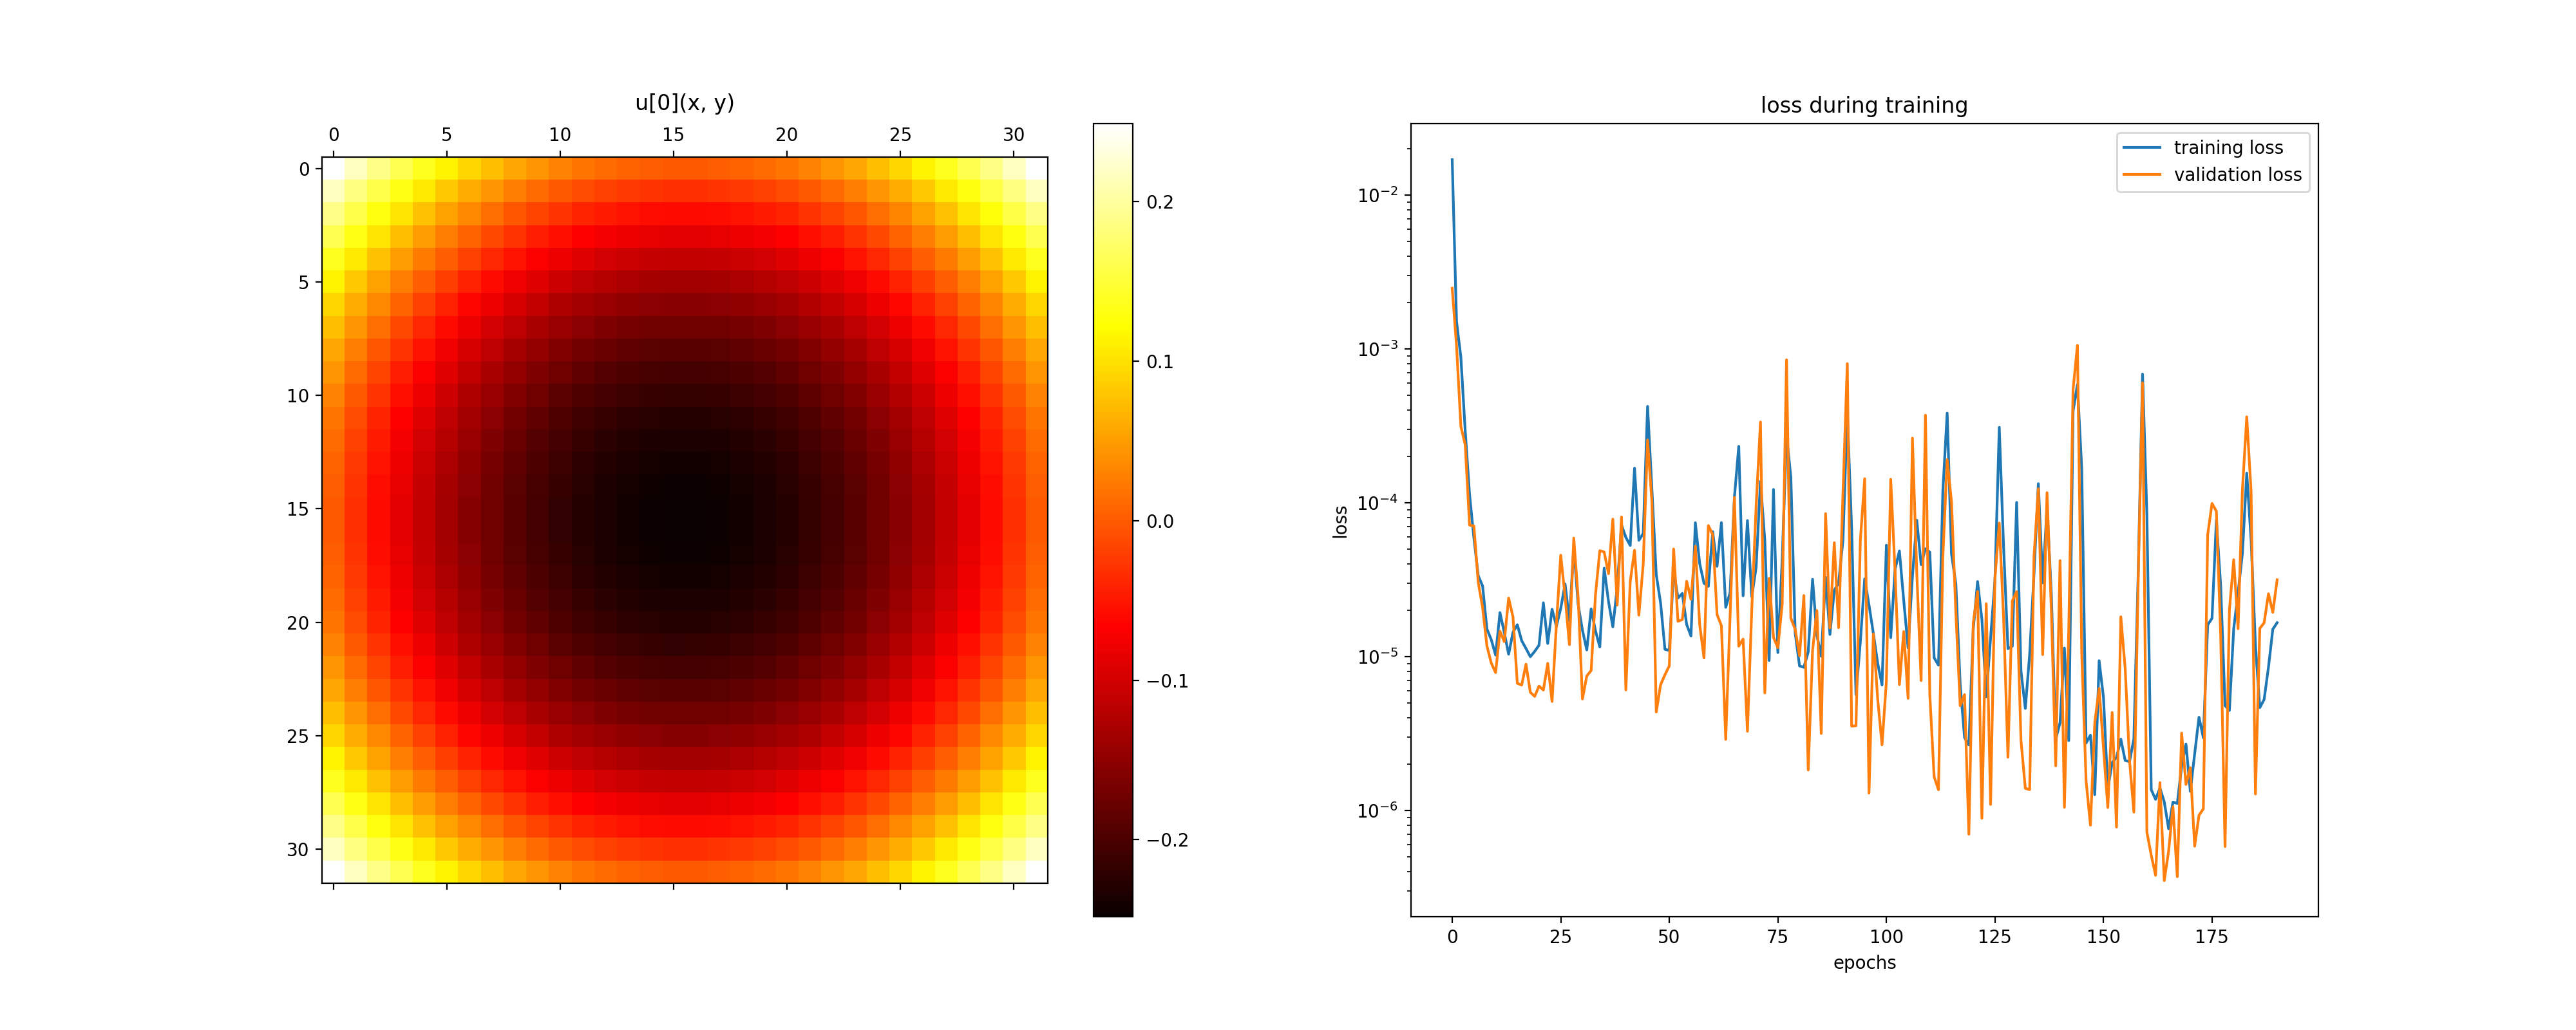

In [8]:
%matplotlib notebook
poisson = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2) - 1
bc  = CircularDirichletHomogeneous(r=1, val=0)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1, actv=nn.Softplus)

solution_neural_net_poisson, _ = solve2D(
    pde=poisson, condition=bc, xy_min=(-1, -1), xy_max=(1, 1),
    net=net, max_epochs=200, train_generator=ExampleGenerator2D(
        (32, 32), (-1, -1), (1, 1), method='equally-spaced-noisy'
    ), return_best=True,
    monitor=Monitor2D(check_every=10, xy_min=(-1, -1), xy_max=(1, 1))
)

In [9]:
def compare_contour(sol_ana, sol_net, xx, yy):
    fig = plt.figure(figsize=(18, 4))

    ax1 = fig.add_subplot(131)
    cs1 = ax1.contourf(xx, yy, sol_net, cmap='coolwarm')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_title('ANN-based solution')
    cbar1 = fig.colorbar(cs1, format='%.0e', ax=ax1)

    ax2 = fig.add_subplot(132)
    cs2 = ax2.contourf(xx, yy, sol_ana, cmap='coolwarm')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_title('analytical solution')
    cbar2 = fig.colorbar(cs2, format='%.0e', ax=ax2)

    ax3 = fig.add_subplot(133)
    cs3 = ax3.contourf(xx, yy, sol_net-sol_ana, cmap='coolwarm')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_aspect('equal', adjustable='box')
    ax3.set_title('residual of ANN-based solution')
    cbar3 = fig.colorbar(cs3, format='%.0e', ax=ax3)

In [10]:
xs, ys = np.linspace(-1, 1, 101), np.linspace(-1, 1, 101)
xx, yy = np.meshgrid(xs, ys)
u_ana = solution_analytical_poisson(xx, yy)
u_net = solution_neural_net_poisson(xx, yy, as_type='np')

<IPython.core.display.Javascript object>


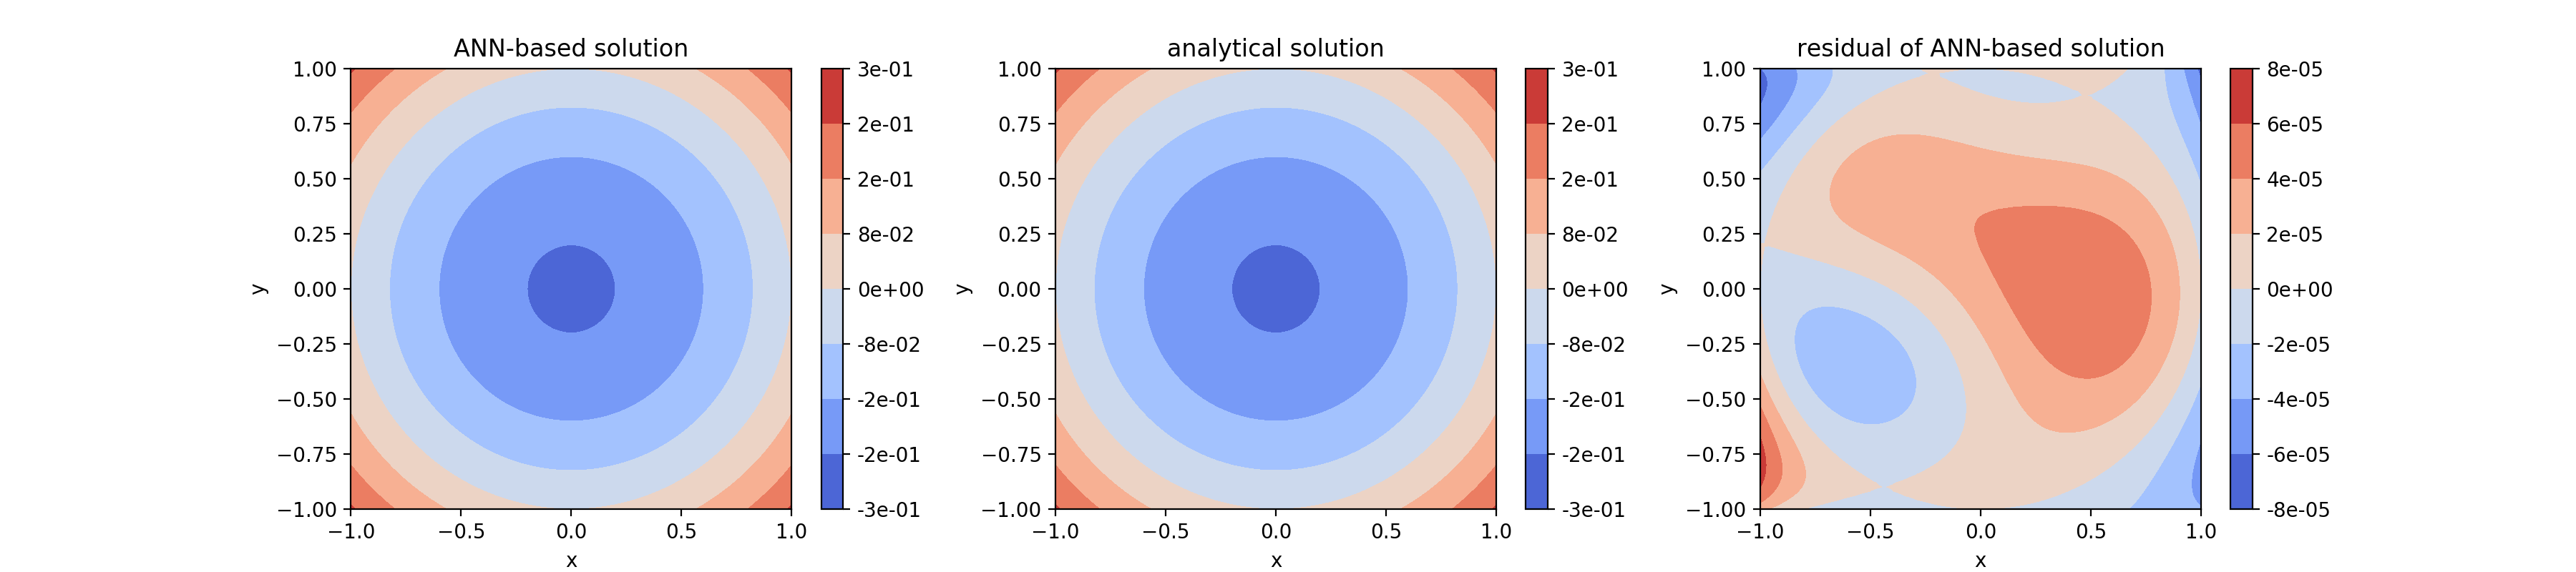

In [11]:
compare_contour(u_ana, u_net, xx, yy)